# Monitoreo de Espacios Verdes   / 4 

### Idea, Secuencia y Suposiciones/Hipotesis

Ya tenemos los estadisticos, vamos a observar algunas graficas
.
#### Suposiciones/Hipotesis

- Utilizamos solo la mascara de nubes provista por sentinel.


In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import geopandas as gpd
import os
import matplotlib.pyplot as plt
from rasterio.plot import plotting_extent
from earthpy import plot
from pathlib import Path
import rasterio as rio
import json
import numpy as np
import pandas as pd

#
from eo_forge.io.SentinelLoaders import Sentinel2Loader

#
import sys

sys.path.append("..")
from src.ioCalc import get_zonal_stats_indexes_all_geom

Los datos concernientes a Córdoba capital los extraemos del set general de datos

In [2]:
gpd_cba = gpd.read_file("../data/cba/espacios-verdes-cba.gpkg")
gpd_cba_crs = gpd_cba.to_crs(32720)

In [3]:
pd_stats = pd.read_csv(
    "../data/cba/espacios-verdes-indexs-cba-20170101-20220420.csv", index_col=0
)

In [4]:
pd_stats.head()

,B02_min,B02_max,B02_mean,B02_median,B02_nodata,B02_range,B02_count,B03_min,B03_max,B03_mean,...,sipi_median,sipi_nodata,sipi_range,sipi_count,raster,clouds_on_raster,osm_id,name,area_m2,date
0,0.0871,0.1421,0.102570,0.09650,0.0,0.0550,47,0.0768,0.1516,0.098885,...,0.884216,0.0,0.453065,47,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,605976736,NaN,4650.710032,2017-01-03
1,0.0970,0.1936,0.118354,0.10660,0.0,0.0966,13,0.1006,0.1949,0.122154,...,0.971875,0.0,0.247045,13,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,559322368,NaN,1502.000513,2017-01-03
2,0.0992,0.1273,0.111805,0.11290,0.0,0.0281,19,0.1037,0.1369,0.117795,...,0.973017,0.0,0.207006,19,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,559322369,NaN,2004.192528,2017-01-03
3,0.0995,0.1933,0.118491,0.11355,0.0,0.0938,66,0.0993,0.1990,0.124512,...,0.966202,0.0,0.258424,66,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,559328111,NaN,6940.507640,2017-01-03
4,0.1059,0.1385,0.122453,0.12240,0.0,0.0326,47,0.1036,0.1580,0.132455,...,0.993986,0.0,0.260419,47,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,559328112,NaN,4587.356048,2017-01-03


In [5]:
pd_stats["name"] = pd_stats["name"].replace(np.NaN, "unknown")

In [6]:
pd_sarmiento = pd_stats[pd_stats.name.str.contains("Sarmiento")]

<AxesSubplot:xlabel='date'>

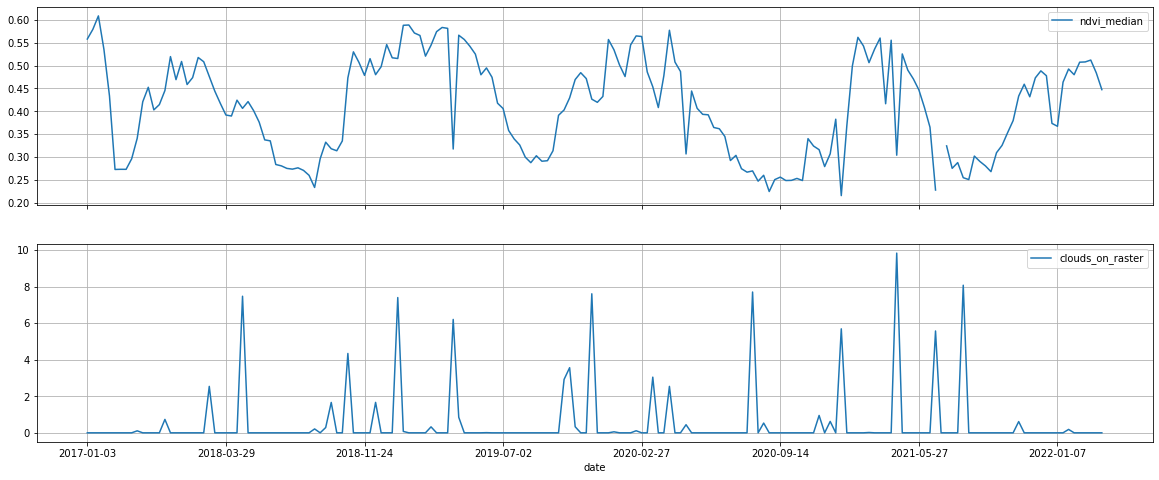

In [7]:
f, ax = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
pd_sarmiento[pd_sarmiento.clouds_on_raster < 10].plot(
    x="date", y="ndvi_median", ax=ax[0], grid=True
)
pd_sarmiento[pd_sarmiento.clouds_on_raster < 10].plot(
    x="date", y="clouds_on_raster", ax=ax[1], grid=True
)

### Forecasting

Vamos a intentar analizar la evolucion de un indice (ndvi) en su mediana. Algunos comentarios:

- Vamos a desechar nubes (clouds_on_raster == 0)
- Vamos a resamplear con una frecuencia mensual

In [8]:
pd_proc = pd_sarmiento.copy()
pd_proc = pd_proc[pd_proc.clouds_on_raster == 0]
pd_proc

,B02_min,B02_max,B02_mean,B02_median,B02_nodata,B02_range,B02_count,B03_min,B03_max,B03_mean,...,sipi_median,sipi_nodata,sipi_range,sipi_count,raster,clouds_on_raster,osm_id,name,area_m2,date
186,0.0751,0.3991,0.104646,0.0987,0.0,0.3240,8588,0.0590,0.4087,0.101785,...,0.902752,0.0,3.402823e+38,8588,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2017-01-03
2851,0.0671,0.4258,0.097588,0.0920,0.0,0.3587,8588,0.0498,0.4176,0.094457,...,0.890146,0.0,4.276148e+01,8588,S2A_MSIL1C_20170212T142031_N0204_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2017-02-12
3608,0.0694,0.3862,0.097503,0.0912,0.0,0.3168,8588,0.0485,0.3957,0.093673,...,0.885194,0.0,3.338491e+01,8588,S2A_MSIL1C_20170222T142031_N0204_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2017-02-22
4368,0.0708,0.3906,0.103186,0.0979,0.0,0.3198,8588,0.0499,0.3976,0.098484,...,0.899257,0.0,1.148243e+02,8588,S2A_MSIL1C_20170314T142031_N0204_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2017-03-14
6990,0.0842,0.4167,0.112552,0.1077,0.0,0.3325,8588,0.0561,0.4200,0.097212,...,0.788568,0.0,3.402823e+38,8588,S2A_MSIL1C_20170602T142041_N0205_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2017-06-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202304,0.0736,0.4086,0.108508,0.1031,0.0,0.3350,8588,0.0525,0.4099,0.104258,...,0.908957,0.0,3.402823e+38,8588,S2B_MSIL1C_20220303T141729_N0400_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2022-03-03
205325,0.0877,0.4009,0.117029,0.1124,0.0,0.3132,8588,0.0623,0.4213,0.109082,...,0.872205,0.0,1.365792e+02,8588,S2B_MSIL1C_20220323T141739_N0400_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2022-03-23
206090,0.0722,0.4869,0.108316,0.1026,0.0,0.4147,8588,0.0489,0.4931,0.103397,...,0.905261,0.0,2.875896e+01,8588,S2A_MSIL1C_20220328T141741_N0400_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2022-03-28
206834,0.0764,0.4496,0.111634,0.1064,0.0,0.3732,8588,0.0527,0.4363,0.106050,...,0.908729,0.0,2.644582e+01,8588,S2B_MSIL1C_20220402T141729_N0400_R010_T20JLL_2...,0.0,6170329,Parque Sarmiento,859608.565917,2022-04-02


In [9]:
pd_proc["date"] = pd.to_datetime(pd_proc["date"], format="%Y-%m-%d")

In [10]:
pd_proc.set_index("date", inplace=True)

In [11]:
df_stats = pd_proc.resample("M").median().bfill()

In [12]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [13]:
from statsmodels.tsa.seasonal import STL

In [14]:
data = df_stats["ndvi_median"]

In [15]:
res = STL(data).fit()

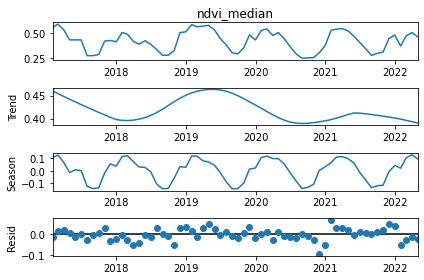

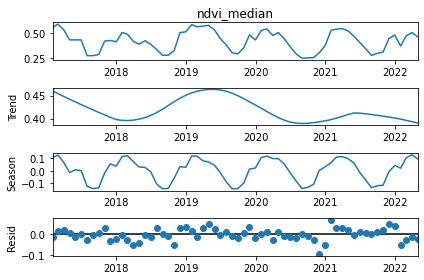

In [16]:
res.plot()

In [17]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [18]:
aust = data[:-12]

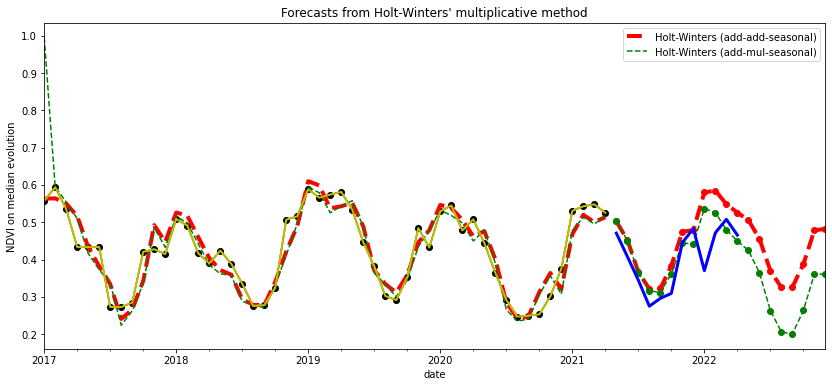

Figure: NDVI Median Forecasting


,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,0.755031,8.992942e-01,7.518613e-01,0.909813
$\beta$,0.000000,3.220929e-17,2.677195e-17,0.000009
$\phi$,NaN,NaN,9.803476e-01,0.904726
$\gamma$,0.000000,9.240112e-19,0.000000e+00,0.000003
$l_0$,-0.523590,6.394878e-17,-5.226608e-01,0.009855
$b_0$,0.000254,-6.029247e-03,-3.764968e-04,-0.010768
SSE,0.078447,2.732157e-01,7.846676e-02,0.274757


In [19]:
fit1 = ExponentialSmoothing(
    aust,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit2 = ExponentialSmoothing(
    aust,
    seasonal_periods=12,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit3 = ExponentialSmoothing(
    aust,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit4 = ExponentialSmoothing(
    aust,
    seasonal_periods=12,
    trend="add",
    seasonal="mul",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = aust.plot(
    figsize=(14, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)
ax.set_ylabel("NDVI on median evolution")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style="--", color="red", lw=4)
fit2.fittedvalues.plot(ax=ax, style="--", color="green")

fit1.forecast(20).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", lw=4, legend=True
)
fit2.forecast(20).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)
data[-12:].plot(ax=ax,c='b',lw=3)
data[:-12].plot(ax=ax,c='y',lw=2)
plt.show()
print("Figure: NDVI Median Forecasting")

results